<a href="https://colab.research.google.com/github/r-o-h-a-n-2004/faster-rcnn-object-detection-/blob/main/faster_rcnn_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 72.5MB/s]


Epoch 1/5 - Loss: 0.6779
Epoch 2/5 - Loss: 0.3703
Epoch 3/5 - Loss: 0.3204
Epoch 4/5 - Loss: 0.2568
Epoch 5/5 - Loss: 0.2472
Training complete!
Model saved!

Testing model on sample images...

Image 1 - Detected pedestrians: 21


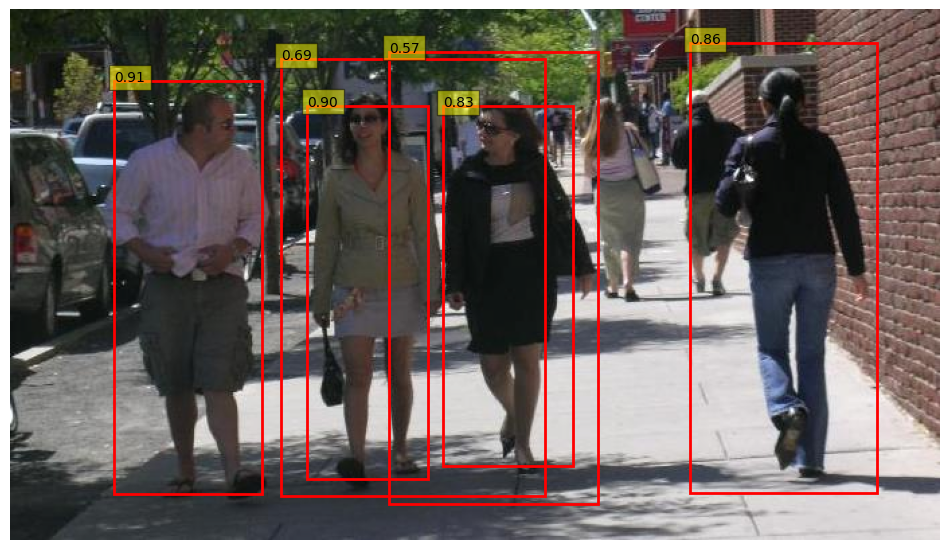


Image 2 - Detected pedestrians: 11


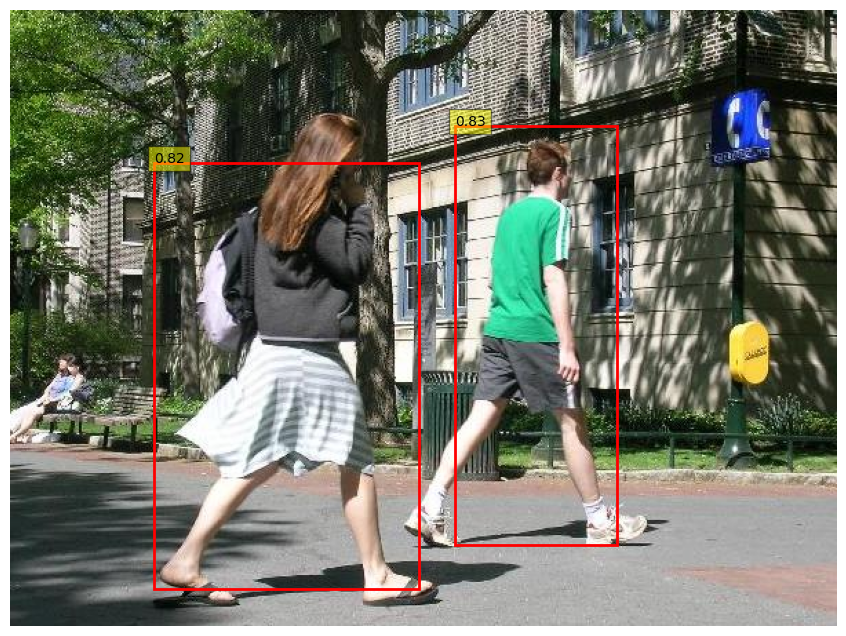


Image 3 - Detected pedestrians: 16


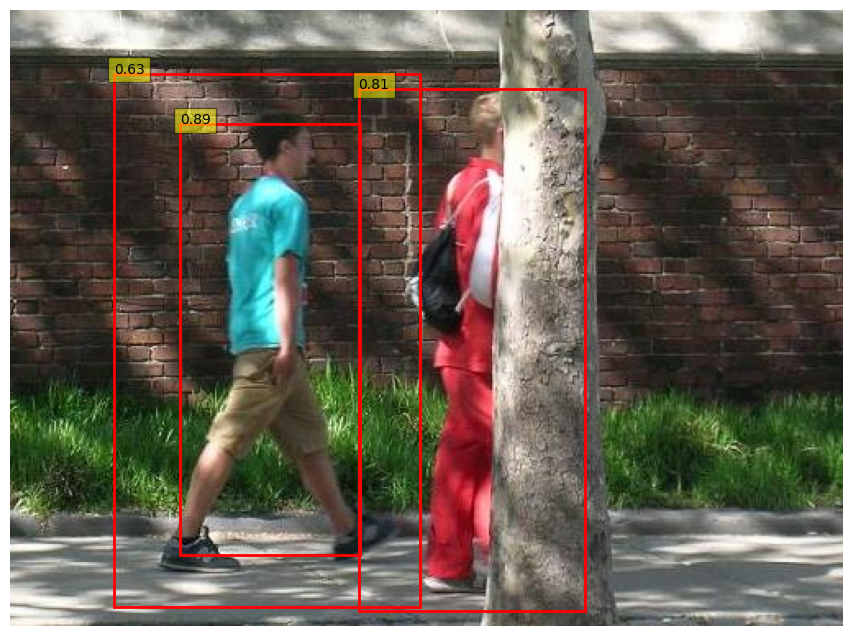


Image 4 - Detected pedestrians: 22


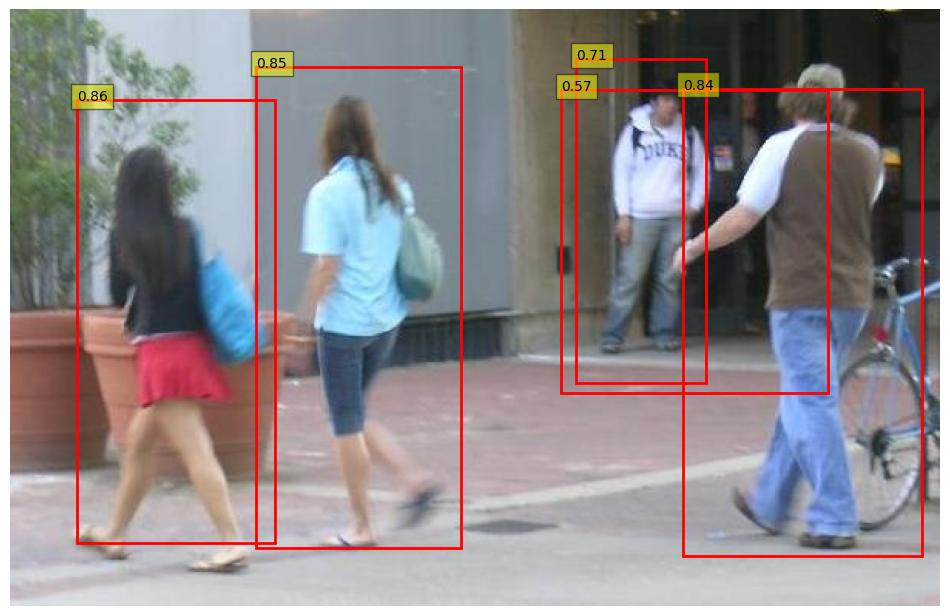


Image 5 - Detected pedestrians: 9


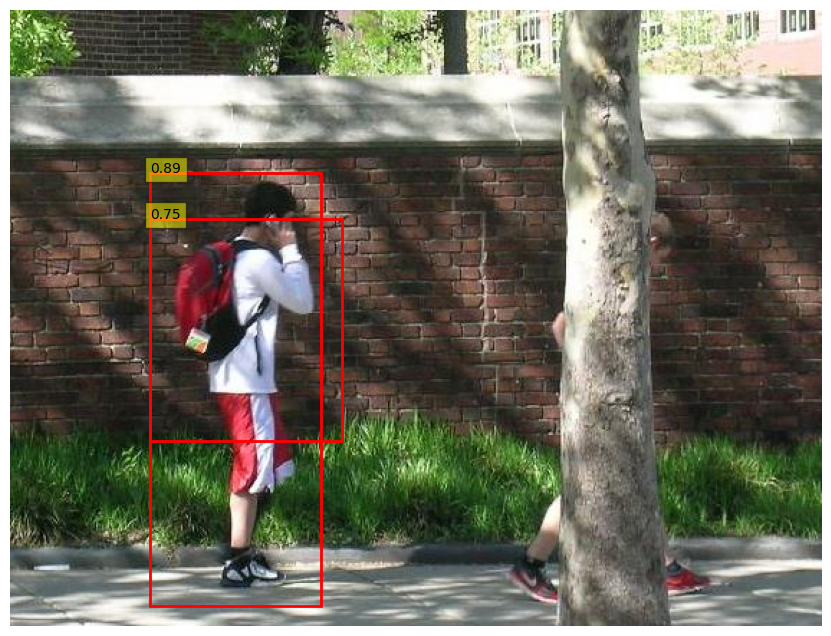

In [1]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2
import random

# Set device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download and extract dataset
!wget -q https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip -q -o PennFudanPed.zip
!rm PennFudanPed.zip

# Custom dataset class
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # Get unique object ids (0 is background)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        # Create binary masks for each object
        masks = mask == obj_ids[:, None, None]

        # Extract bounding boxes
        boxes = []
        for i in range(len(obj_ids)):
            pos = np.where(masks[i])
            xmin, xmax = np.min(pos[1]), np.max(pos[1])
            ymin, ymax = np.min(pos[0]), np.max(pos[0])
            # Ensure boxes have valid dimensions
            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # All pedestrians
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms if specified
        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Data transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])

# Create dataset instances
dataset = PennFudanDataset("PennFudanPed", transforms=transform)

# Split dataset (80% train, 20% test)
indices = torch.randperm(len(dataset)).tolist()
split_idx = int(0.8 * len(dataset))
train_dataset = torch.utils.data.Subset(dataset, indices[:split_idx])
test_dataset = torch.utils.data.Subset(dataset, indices[split_idx:])

# Custom collate function to handle varying numbers of objects
def collate_fn(batch):
    return tuple(zip(*batch))

# Data loaders
train_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True,
    num_workers=2, collate_fn=collate_fn)

test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False,
    num_workers=2, collate_fn=collate_fn)

# Create model with MobileNetV3 backbone
def create_faster_rcnn(num_classes):
    # Load pretrained MobileNetV3 features
    backbone = torchvision.models.mobilenet_v3_small(pretrained=True).features
    backbone.out_channels = 576  # Output channels from MobileNetV3 small

    # Anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # ROI pooling
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    # Create Faster R-CNN model
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

# Initialize model
num_classes = 2  # Background + pedestrian
model = create_faster_rcnn(num_classes)
model.to(device)

# Optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training function
def train_model(model, optimizer, data_loader, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        lr_scheduler.step()
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss/len(data_loader):.4f}")

    print("Training complete!")

# Train the model
train_model(model, optimizer, train_loader, num_epochs=5)

# Save trained model
torch.save(model.state_dict(), 'faster_rcnn_pedestrian.pth')
print("Model saved!")

# Visualization function
def visualize_detections(image, boxes, scores=None, threshold=0.5):
    """Draw bounding boxes on image"""
    # Convert tensor to numpy array and denormalize
    img = image.cpu().permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for i, box in enumerate(boxes):
        if scores is not None and scores[i] < threshold:
            continue

        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        if scores is not None:
            ax.text(xmin, ymin, f'{scores[i]:.2f}',
                    bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()

# Test the model
def test_model(model, data_loader, num_samples=5):
    model.eval()
    sample_count = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)

            # Visualize results
            for i in range(len(images)):
                img = images[i].cpu()
                boxes = predictions[i]['boxes'].cpu()
                scores = predictions[i]['scores'].cpu()

                print(f"\nImage {sample_count + 1} - Detected pedestrians: {len(boxes)}")
                visualize_detections(img, boxes, scores)

                sample_count += 1
                if sample_count >= num_samples:
                    return

# Run evaluation on test images
print("\nTesting model on sample images...")
test_model(model, test_loader, num_samples=5)